In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model = joblib.load('../result/outputs/lgbm_melting_point_model_20251219_180157.joblib')

In [2]:
import sklearn 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb

work_df = pd.read_csv('../result/data/melting_point_features_with_type.csv')
print(work_df.head())


                                   SMILES     Tm  MaxAbsEStateIndex  \
0                                 CC(O)CN   34.5           8.236111   
1  O=[N+]([O-])c1ccc(Cl)c([N+](=O)[O-])c1  -65.2          10.295093   
2                                  ClCCCl  -31.5           5.054012   
3                      Clc1ccc(Cl)c(Cl)c1   63.0           5.597562   
4                      O=C(O)c1cccc(O)c1O  399.2          10.302871   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0        8.236111           0.337963       -0.337963  0.433755  15.000000   
1       10.295093           0.115185       -0.768518  0.543108   9.615385   
2        5.054012           0.557099        0.557099  0.436304   7.500000   
3        5.597562           0.489969        0.489969  0.536102   9.666667   
4       10.302871           0.300926       -1.265370  0.522491   9.454545   

     MolWt  HeavyAtomMolWt  ...  MurckoAtoms  SideChainAtoms  FormalCharge  \
0   75.111          66.039  ... 

In [3]:

work_df = work_df[work_df['chem_type'] == 'organic (heteroatom-containing)'].reset_index(drop=True)
print(work_df.shape)

(9246, 940)


In [4]:
# Outlier removal 
Tm = work_df['Tm'].astype(float)
 
lower = -250
upper = 750

mask = (Tm >= lower) & (Tm <= upper)
removed = int((~mask).sum())
total = int(len(work_df))
pct_removed = 100.0 * removed / total if total else 0.0

print(f"IQR bounds for Tm: [{lower:.3f}, {upper:.3f}]")
print(f"Removed outliers: {removed}/{total} ({pct_removed:.2f}%)")

# Apply filter
work_df = work_df.loc[mask].reset_index(drop=True)
feature_cols = [c for c in work_df.columns if c not in ('Tm', 'SMILES')]
X = work_df[feature_cols].select_dtypes(include=['number'])
y = work_df['Tm'].astype(float)
#y_transformed = np.sign(y) * np.log1p(np.abs(y)) add log transform

print('After outlier removal -> Rows:', len(work_df), 'Numeric features:', X.shape[1])


IQR bounds for Tm: [-250.000, 750.000]
Removed outliers: 332/9246 (3.59%)
After outlier removal -> Rows: 8914 Numeric features: 937


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)
y_pred = model.predict(X_valid)

RMSE: 90.893
MAE: 47.934
R²: 0.768


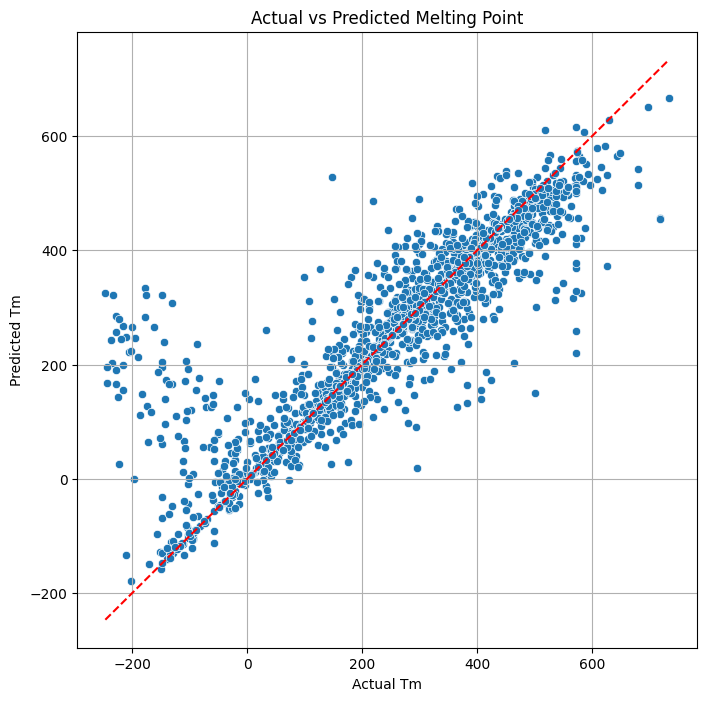

In [6]:
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_valid, y=y_pred)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel('Actual Tm')
plt.ylabel('Predicted Tm')
plt.title('Actual vs Predicted Melting Point')
plt.grid()
plt.show()

Outliers (Actual Tm < 0 and Predicted Tm > 100):
      Actual Tm  Predicted Tm
2885     -131.8    166.279768
6022     -243.4    167.776823
3204     -175.0    127.173469
4562     -225.4    143.103281
2992     -229.2    166.286711
2348     -178.6    334.054062
3095     -216.4    154.850759
315      -131.8    307.895076
5933     -148.0    195.515376
4503     -211.0    248.830501
6066     -247.0    325.547645
3590     -148.0    205.040372
2473     -205.6    221.572809
3213      -97.6    121.208273
5593     -186.7    110.777141
2984     -148.0    321.114695
511      -106.6    205.835184
5058     -238.0    243.477075
733      -155.2    187.709100
3806      -72.4    126.317162
1188     -216.4    200.002846
7444     -106.6    103.035657
6124     -202.0    224.331310
2404      -63.4    124.930594
1957     -229.0    285.661523
2018     -184.0    149.279841
2683     -143.6    140.423903
2254     -108.4    170.906031
3469     -162.4    265.450914
4967      -34.6    105.766888
3290      -59.8    14

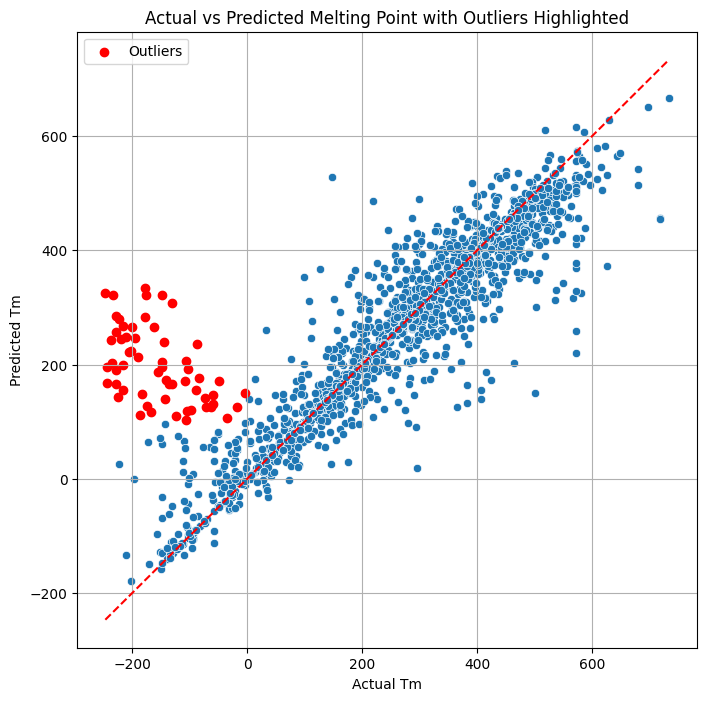

In [8]:
# group preticted outliers with atrual TM from -200 to 0 

outlier_mask = (y_valid < 0) & (y_pred > 100)
outliers = pd.DataFrame({
    'Actual Tm': y_valid[outlier_mask],
    'Predicted Tm': y_pred[outlier_mask]
})
print("Outliers (Actual Tm < 0 and Predicted Tm > 100):")
print(outliers)
# get outlier data
outliers_df = work_df.loc[y_valid.index[outlier_mask]]
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_valid, y=y_pred)
plt.scatter(y_valid[outlier_mask], y_pred[outlier_mask], color='red', label='Outliers')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel('Actual Tm')
plt.ylabel('Predicted Tm')
plt.title('Actual vs Predicted Melting Point with Outliers Highlighted')
plt.legend()
plt.grid()
plt.show()